In [21]:
import keras
from keras.layers import Conv1D, Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import pandas as pd
import numpy as np
!pip install spectral
import spectral
import matplotlib.pyplot as plt
init_notebook_mode(connected=True)
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
def read_HSI():
  X = loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
  y = loadmat('Indian_pines_gt.mat')['indian_pines_gt']
  print(f"X shape: {X.shape}\ny shape: {y.shape}")
  return X, y


In [23]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
    return newX, pca

In [24]:
def padWithZeros(X, margin=2):
    newX = np.zeros(
        (X.shape[0] + 2 * margin, X.shape[1] + 2 * margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX


In [25]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels=True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    print(X.shape[0], X.shape[1], X.shape[2], zeroPaddedX.shape)
    patchesData = np.zeros(
        (X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin,2):
        for c in range(margin, zeroPaddedX.shape[1] - margin,2):
            patch = zeroPaddedX[r - margin:r +
                                margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels > 0, :, :, :]
        patchesLabels = patchesLabels[patchesLabels > 0]
        patchesLabels -= 1
    return patchesData, patchesLabels


In [26]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [27]:
def Patch(data, height_index, width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]

    return patch

In [28]:
test_ratio = 0.7
windowSize = 25

# INDIAN PINES **1DCNN**

In [29]:
X, y = read_HSI()

X shape: (145, 145, 200)
y shape: (145, 145)


In [30]:
K=30

In [31]:
X, pca = applyPCA(X, numComponents=K)

X.shape


(145, 145, 30)

In [32]:
print(X.shape)
print(y.shape)

(145, 145, 30)
(145, 145)


In [33]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

145 145 30 (169, 169, 30)


((2560, 25, 25, 30), (2560,))

In [34]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test


In [35]:
y

array([2., 2., 2., ..., 9., 9., 9.])

In [36]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)
print(Xtrain.shape)
print(Xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(768, 25, 25, 30)
(1792, 25, 25, 30)
(768,)
(1792,)


In [37]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(768, 16)

In [38]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(768, 25, 25, 30, 1)

In [39]:

S = windowSize
L = K
output_units =16

In [40]:
## input layer
input_layer = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(
    3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(
    3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(
    3, 3, 3), activation='relu')(conv_layer2)
print(conv_layer3.shape)

flatten_layer = Flatten()(conv_layer3)

print(conv_layer3.shape, flatten_layer.shape)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)


(None, 19, 19, 18, 32)
(None, 19, 19, 18, 32) (None, 207936)


In [41]:
model = Model(inputs=input_layer, outputs=output_layer)

In [42]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 25, 25, 30, 1)]   0         
                                                                 
 conv3d_3 (Conv3D)           (None, 23, 23, 24, 8)     512       
                                                                 
 conv3d_4 (Conv3D)           (None, 21, 21, 20, 16)    5776      
                                                                 
 conv3d_5 (Conv3D)           (None, 19, 19, 18, 32)    13856     
                                                                 
 flatten_1 (Flatten)         (None, 207936)            0         
                                                                 
 dense (Dense)               (None, 256)               53231872  
                                                                 
 dropout (Dropout)           (None, 256)               0     

In [43]:
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy',
              optimizer=adam, metrics=['accuracy'])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [44]:
filepath = "./best_model_3dcnn.hdf5"
checkpoint = ModelCheckpoint(
    filepath, monitor='acc', verbose=1, save_weights_only=True, mode='max')
callbacks_list = [checkpoint]

In [45]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=256,
                    epochs=25, callbacks=callbacks_list)

Epoch 1/25
3/3 [==============================] - ETA: 0s - loss: 10.6564 - accuracy: 0.1302
Epoch 1: saving model to ./best_model_3dcnn.hdf5
3/3 [==============================] - 14s 744ms/step - loss: 10.6564 - accuracy: 0.1302
Epoch 2/25
3/3 [==============================] - ETA: 0s - loss: 3.1828 - accuracy: 0.1016
Epoch 2: saving model to ./best_model_3dcnn.hdf5
3/3 [==============================] - 2s 713ms/step - loss: 3.1828 - accuracy: 0.1016
Epoch 3/25
3/3 [==============================] - ETA: 0s - loss: 2.5615 - accuracy: 0.1823
Epoch 3: saving model to ./best_model_3dcnn.hdf5
3/3 [==============================] - 2s 945ms/step - loss: 2.5615 - accuracy: 0.1823
Epoch 4/25
3/3 [==============================] - ETA: 0s - loss: 2.5417 - accuracy: 0.1849
Epoch 4: saving model to ./best_model_3dcnn.hdf5
3/3 [==============================] - 2s 702ms/step - loss: 2.5417 - accuracy: 0.1849
Epoch 5/25
3/3 [==============================] - ETA: 0s - loss: 2.4174 - accuracy: 

In [46]:
model.load_weights("./best_model_3dcnn.hdf5")

model.compile(loss='categorical_crossentropy',
              optimizer=adam, metrics=['accuracy'])

In [47]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(1792, 25, 25, 30, 1)

In [48]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(1792, 16)

In [49]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)


56/56 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

           0       0.86      0.67      0.75         9
           1       0.85      0.82      0.84       249
           2       0.83      0.91      0.87       150
           3       0.96      0.66      0.78        38
           4       0.98      0.69      0.81        83
           5       0.98      1.00      0.99       125
           6       1.00      0.33      0.50         6
           7       0.90      1.00      0.95        78
           8       0.00      0.00      0.00         3
           9       0.88      0.96      0.92       166
          10       0.91      0.96      0.93       438
          11       0.80      0.71      0.75       102
          12       1.00      0.97      0.99        38
          13       0.98      0.96      0.97       221
          14       0.80      0.91      0.85        70
          15       0.79      0.69      0.73        16

    accuracy               

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [50]:
def reports(X_test, y_test):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)

    target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn', 'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed',
                    'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                    'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                    'Stone-Steel-Towers']

    classification = classification_report(
        np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss = score[0]*100
    Test_accuracy = score[1]*100

    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [51]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest)

56/56 [==============================] - 1s 11ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



56/56 [==============================] - 1s 10ms/step - loss: 0.3330 - accuracy: 0.8979


In [52]:
classification = str(classification)
confusion = str(confusion)
print(classification)
print(confusion)


                              precision    recall  f1-score   support

                     Alfalfa       0.86      0.67      0.75         9
                 Corn-notill       0.85      0.82      0.84       249
                Corn-mintill       0.83      0.91      0.87       150
                        Corn       0.96      0.66      0.78        38
               Grass-pasture       0.98      0.69      0.81        83
                 Grass-trees       0.98      1.00      0.99       125
         Grass-pasture-mowed       1.00      0.33      0.50         6
               Hay-windrowed       0.90      1.00      0.95        78
                        Oats       0.00      0.00      0.00         3
              Soybean-notill       0.88      0.96      0.92       166
             Soybean-mintill       0.91      0.96      0.93       438
               Soybean-clean       0.80      0.71      0.75       102
                       Wheat       1.00      0.97      0.99        38
                   

In [53]:
file_name = "classification_report_3dcnn.txt"

In [54]:
with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

In [55]:
X, y = read_HSI()

X shape: (145, 145, 200)
y shape: (145, 145)


In [56]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [57]:
X,pca = applyPCA(X, numComponents=numComponents)

In [58]:
X = padWithZeros(X, PATCH_SIZE//2)

In [59]:
# calculate the predicted image
outputs = np.zeros((height, width))
for i in range(height):
    for j in range(width):
        target = int(y[i, j])
        if target == 0:
            continue
        else:
            image_patch = Patch(X, i, j)
            X_test_image = image_patch.reshape(
                1, image_patch.shape[0], image_patch.shape[1], image_patch.shape[2], 1).astype('float32')
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 38ms/step


/usr/local/lib/python3.9/dist-packages/spectral/graphics/spypylab.py:796: UserWarning:

Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.



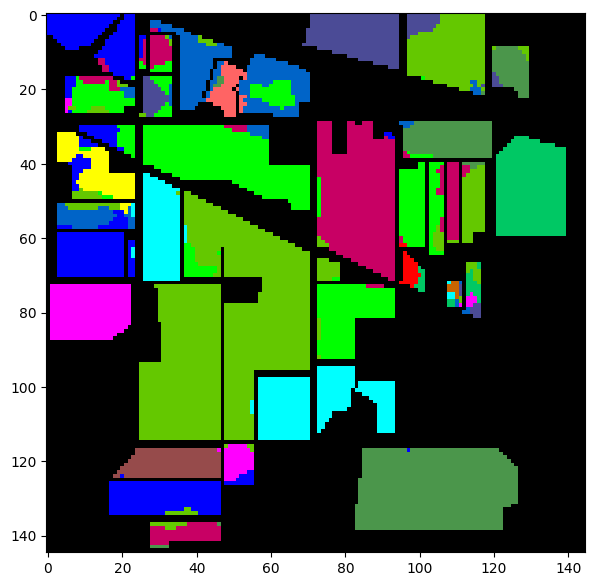

In [60]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

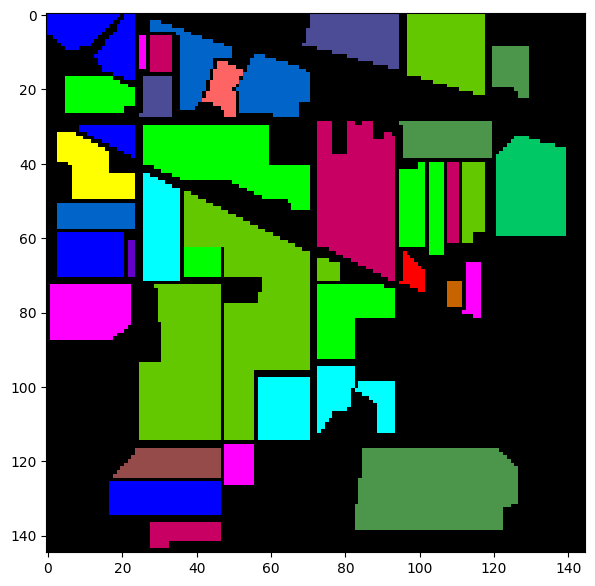

In [61]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))